In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import datetime
import tidypolars as tp
from tidypolars import col

import warnings
warnings.filterwarnings('ignore')

In [45]:
nga_cases = pd.read_csv("https://raw.githubusercontent.com/dsfsi/covid19africa/master/data/line_lists/line-list-nigeria.csv")

# add count column to sum
nga_cases['count'] = 1

# replace 'Abuja' with 'Federal Capital Territory' to match map data state names
nga_cases['province/state'][nga_cases['province/state'] == 'Abuja'] = 'Federal Capital Territory'

print(nga_cases.shape)
nga_cases.head()

(6401, 21)


,case_id,origin_case_id,date,age,gender,city,province/state,country,current_status,source,...,date_onset_symptoms,date_admission_hospital,date_confirmation,underlying_conditions,travel_history_dates,travel_history_location,death_date,notes_for_discussion,Unnamed: 19,count
0,1,NaN,2/27/2020,44,Male,Ogun,Ogun,Nigeria,In recovery,www.bbc.com,...,NaN,2/27/2020,27-Feb-20,No,NaN,Italy,NaN,Patient came in from Italy.,NaN,1
1,2,NaN,03/09/2020,NaN,NaN,Ogun,Ogun,Nigeria,In treatment,https://twitter.com/NCDCgov/status/12376418124...,...,03/09/2020,03/09/2020,03/09/2020,No,NaN,NaN,NaN,NaN,NaN,1
2,3,NaN,3/16/2020,30,Female,Lagos,Lagos,Nigeria,Clinically Stable,https://twitter.com/NCDCgov/status/12398485450...,...,NaN,3/17/2020,3/17/2020,NaN,13-Mar-20,United Kingdom,NaN,Patient returned from trip to UK and was in 14...,NaN,1
3,4,NaN,3/16/2020,58,Male,Lagos,Lagos,Nigeria,NaN,https://twitter.com/NCDCgov/status/12405579967...,...,NaN,NaN,NaN,NaN,13-Mar-20,USA,NaN,Patient returned from travel to USA,NaN,1
4,5,NaN,3/16/2020,38,Female,NaN,Ekiti,Nigeria,NaN,https://twitter.com/NCDCgov/status/12405579967...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Patient made contact with traveler from the USA,NaN,1


In [42]:
nga_cases['province/state'].sort_values().unique()

array(['Abia', 'Abuja', 'Adamawa', 'Akwa Ibom', 'Anambra', 'Bauchi',
       'Bayelsa', 'Benue', 'Borno', 'Delta', 'Ebonyi', 'Edo', 'Ekiti',
       'Enugu', 'Gombe', 'Imo', 'Jigawa', 'Kaduna', 'Kano', 'Katsina',
       'Kebbi', 'Kwara', 'Lagos', 'Nasarawa', 'Niger', 'Ogun', 'Ondo',
       'Osun', 'Oyo', 'Plateau', 'Rivers', 'Sokoto', 'Taraba', 'Yobe',
       'Zamfara'], dtype=object)

In [43]:
nga_admpop_1['ADM1_NAME'].unique()

array(['ABIA', 'ADAMAWA', 'AKWA IBOM', 'ANAMBRA', 'BAUCHI', 'BAYELSA',
       'BENUE', 'BORNO', 'CROSS RIVER', 'DELTA', 'EBONYI', 'EDO', 'EKITI',
       'ENUGU', 'FEDERAL CAPITAL TERRITORY', 'GOMBE', 'IMO', 'JIGAWA',
       'KADUNA', 'KANO', 'KATSINA', 'KEBBI', 'KOGI', 'KWARA', 'LAGOS',
       'NASARAWA', 'NIGER', 'OGUN', 'ONDO', 'OSUN', 'OYO', 'PLATEAU',
       'RIVERS', 'SOKOTO', 'TARABA', 'YOBE', 'ZAMFARA'], dtype=object)

In [3]:
nga_cases.isna().sum()

case_id                       0
origin_case_id             6401
date                          0
age                        6391
gender                     6389
city                       6385
province/state                0
country                       0
current_status             6020
source                        0
symptoms                   6017
date_onset_symptoms        6400
date_admission_hospital    6397
date_confirmation          6374
underlying_conditions      6397
travel_history_dates       6386
travel_history_location    6369
death_date                 6400
notes_for_discussion       6362
Unnamed: 19                6399
count                         0
dtype: int64

## Cases by State

There is only one case with a death date so can't explore analysis on death rates.

In [4]:
sum(nga_cases['death_date'].notnull() * 1)

1

In [31]:
# select columns & group by date + state
state_case_dates = (
    tp.from_pandas(nga_cases)
    .select('date', 'province/state', 'count')
    .summarize(total_cases = tp.sum(col('count')),
               by = ['date', 'province/state'])
)

state_case_dates = state_case_dates.to_pandas()

In [32]:
state_case_dates.head()

,date,province/state,total_cases
0,4/17/2020,Kwara,5
1,05/16/2020,Jigawa,6
2,05/07/2020,Rivers,3
3,05/04/2020,Kano,23
4,04/01/2020,Ogun,2


## Travel History Location

Exploring the most common travel locations for people diagnosed with COVID in Nigeria

Changing United Kingdom to 'UK' to combine

In [7]:
nga_cases['travel_history_location'][nga_cases['travel_history_location'] == 'United Kingdom'] = 'UK'

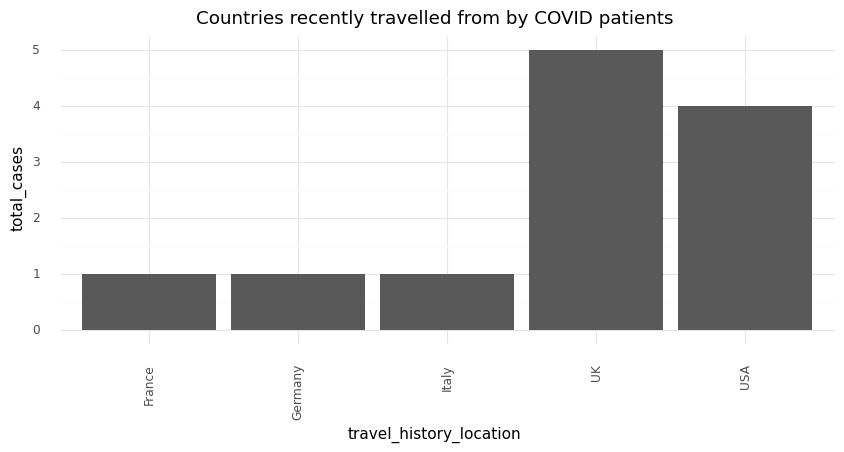

<ggplot: (131636855459)>

In [8]:
nga_travel = nga_cases[nga_cases['travel_history_location'].notnull()]

# select columns & group by date + state
travel_location_cases = (
    tp.from_pandas(nga_travel)
    .filter(col('travel_history_location') != 'High risk country')
    .select('travel_history_location', 'count')
    .summarize(total_cases = tp.sum(col('count')),
               by = 'travel_history_location')
)

travel_location_cases = travel_location_cases.to_pandas()

travel_location_cases.sort_values('total_cases', ascending=False)

# plot cases by location
(ggplot(travel_location_cases, aes('travel_history_location', 'total_cases'))
 + geom_col()
 + ggtitle('Countries recently travelled from by COVID patients')
 + geom_smooth()
 + theme_minimal()
 + theme(axis_text_x = element_text(rotation=90),
        figure_size = (10, 4)))

## Sources

In [9]:
# group and summarise with tp
case_source = (
    tp.from_pandas(nga_cases)
    .summarize(total_cases = tp.sum(col('count')),
               by = 'source')
)

case_source = case_source.to_pandas()
case_source.head()

,source,total_cases
0,https://twitter.com/NCDCgov/status/12416019481...,3
1,https://twitter.com/NCDCgov/status/12508969897...,35
2,https://twitter.com/NCDCgov/status/12606986188...,182
3,https://twitter.com/NCDCgov/status/12541833371...,87
4,https://twitter.com/NCDCgov/status/12552716312...,195


## Cases by date

Exploring the spread of COIVD by looking at cases by date

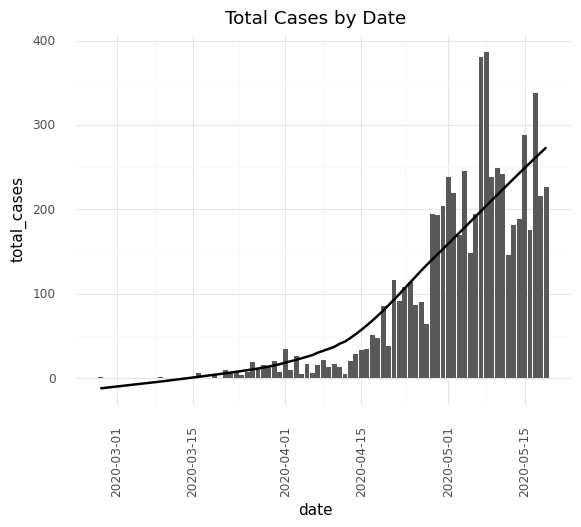

<ggplot: (131637366516)>

In [10]:
# group and summarise with tp
case_dates = (
    tp.from_pandas(nga_cases)
    .summarize(total_cases = tp.sum(col('count')),
               by = 'date')
)

# convert back to pandas and convert to date
cases_df = case_dates.to_pandas()
cases_df['date'] = pd.to_datetime(cases_df['date'])

# plot cases by date
(ggplot(cases_df, aes('date', 'total_cases'))
 + geom_col()
 + ggtitle('Total Cases by Date')
 + geom_smooth()
 + theme_minimal()
 + theme(axis_text_x = element_text(rotation=90)))

In [11]:
hospital_data = pd.read_csv("data/healthmopupandbaselinenmisfacility.csv")
print(hospital_data.shape)
hospital_data.head()

(34139, 30)


,facility_name,facility_type_display,maternal_health_delivery_services,emergency_transport,skilled_birth_attendant,num_chews_fulltime,phcn_electricity,c_section_yn,child_health_measles_immun_calc,num_nurses_fulltime,...,antenatal_care_yn,family_planning_yn,malaria_treatment_artemisinin,sector,formhub_photo_id,gps,survey_id,unique_lga,latitude,longitude
0,HEALTH POST KAGBANG,Health Post,True,True,False,1.0,True,False,True,0.0,...,True,False,True,health,1393335750723.jpg,6.54340807 9.08470312 218.8000030517578 5.0,451a0efb-5fa6-4bad-93cd-7cf19eb50833,cross_river_obudu,6.543408,9.084703
1,Alhari Clinic,Primary Health Centre (PHC),True,True,True,4.0,True,False,True,1.0,...,True,False,True,health,1393316873034.jpg,9.00720861 7.67780798 432.8999938964844 5.0,5ddb68d6-02d2-44de-9df3-ebc840a1da42,nasarawa_karu,9.007209,7.677808
2,Primary health centre umukuru okehi,Basic Health Centre / Primary Health Clinic,True,True,True,2.0,True,True,True,4.0,...,True,True,True,health,1393594715772.jpg,5.1297 7.1592 73.3 5,2173b656-14eb-400d-9eef-76830379b065,rivers_etche,5.129700,7.159200
3,PHC EHOM CENTRAL,Primary Health Centre (PHC),True,False,False,2.0,False,False,True,0.0,...,True,True,True,health,1393330657159.jpg,5.4633 8.1464 117.8 5,963abf9d-5a72-4b35-811e-9c1830adc88b,cross_river_biase,5.463300,8.146400
4,Health post,Health Post,True,False,False,0.0,False,False,True,0.0,...,True,True,True,health,1393342042946.jpg,5.504 8.0251 52.4 5,9d09aaac-578c-4a48-a054-dee678a05422,cross_river_biase,5.504000,8.025100


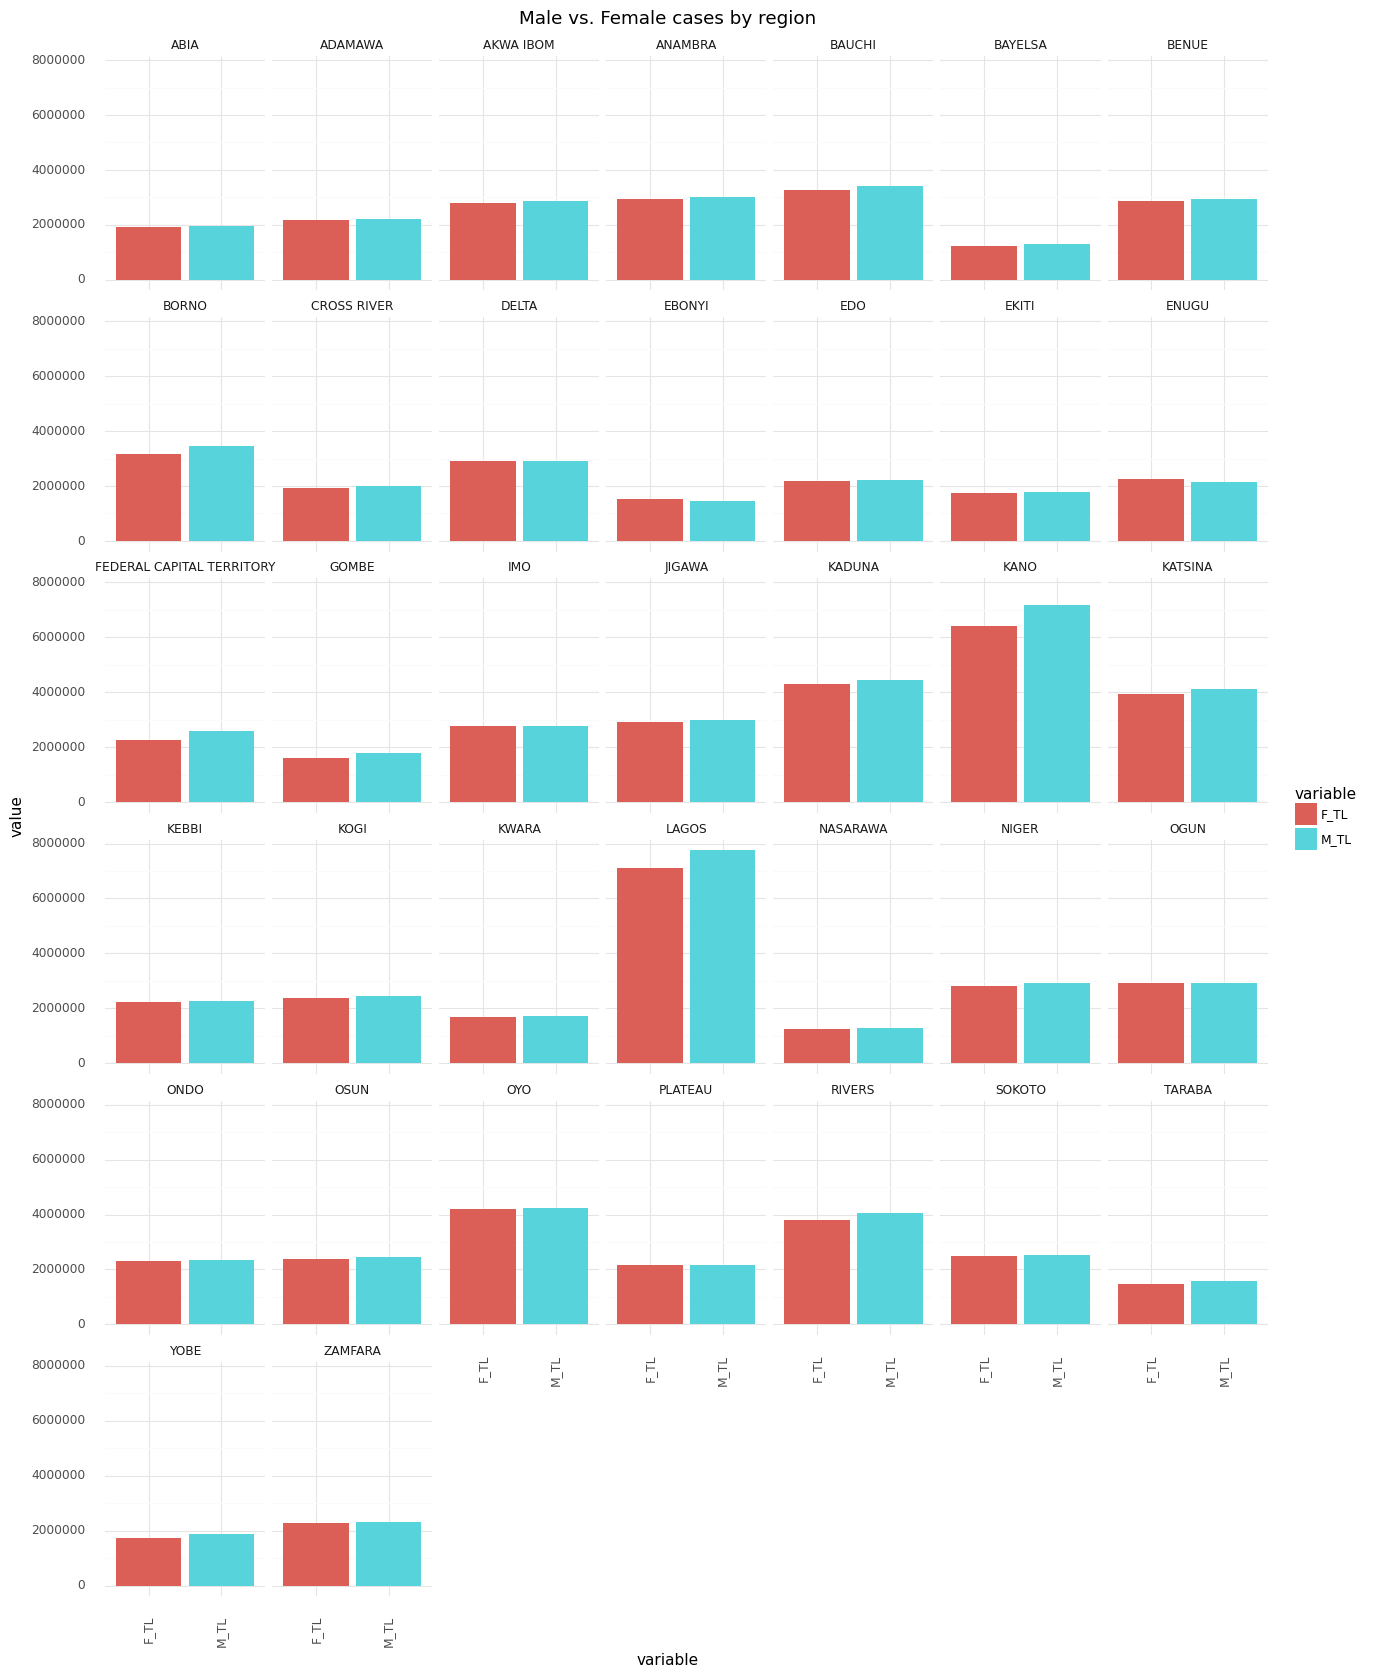

<ggplot: (131637467161)>

In [12]:
nga_admpop_1 = pd.read_csv("data/nga_admpop_adm1_2020.csv")
nga_admpop_1.head()

# group and summarise with tp
adm1_sel = (
    tp.from_pandas(nga_admpop_1)
    .select('ADM1_NAME', 'F_TL', 'M_TL')
    .summarize(F_TL = tp.sum(col('F_TL')),
               M_TL = tp.sum(col('M_TL')),
               by = 'ADM1_NAME')
)

adm1 = adm1_sel.to_pandas()

adm1 = pd.melt(adm1, id_vars='ADM1_NAME', value_vars=['F_TL', 'M_TL'])

adm1_plot = (ggplot(adm1, aes('variable', 'value'))
 + geom_col(aes(fill='variable'))
 + ggtitle('Male vs. Female cases by region')
 + theme_minimal()
 + theme(axis_text_x = element_text(rotation=90),
        figure_size = (15,20))
 + facet_wrap('~ADM1_NAME'))

adm1_plot

## Combining state cases, population and location data

In [13]:
# group and summarise with tp
adm1_plot = (
    tp.from_pandas(nga_admpop_1)
    .select('ADM1_PCODE', 'T_TL')
    .summarize(T_TL = tp.sum(col('T_TL')),
               by = 'ADM1_PCODE')
)

adm1_plot = adm1_plot.to_pandas()
adm1_plot.rename(columns = {'ADM1_PCODE':'admin1Pcode', 'T_TL':'population'}, inplace = True)

adm1_plot.head()

,admin1Pcode,population
0,NG026,2557000
1,NG036,3619142
2,NG025,14879754
3,NG007,5814928
4,NG015,4834747


In [14]:
# create adm1 lookup
adm_lkp = (
    tp.from_pandas(nga_admpop_1)
    .select('ADM1_NAME', 'ADM1_PCODE')
)

adm_lkp = adm_lkp.to_pandas()

In [15]:
# group and summarise with tp
state_case_sel = (
    tp.from_pandas(state_case_dates)
    .select('date', 'province/state', 'total_cases')
)

state_case_sel = state_case_sel.to_pandas()
state_case_sel['ADM1_NAME'] = state_case_sel['province/state'].str.upper()
state_case_sel = state_case_sel.drop('province/state', axis=1)
state_case_sel['date'] = pd.to_datetime(state_case_sel['date'])

state_case_sel.head()

,date,total_cases,ADM1_NAME
0,2020-05-01,3,EKITI
1,2020-05-19,1,ENUGU
2,2020-04-24,75,LAGOS
3,2020-05-08,4,RIVERS
4,2020-04-18,1,JIGAWA


Join cases and PCODES

In [16]:
state_cases = state_case_sel.merge(adm_lkp, on = "ADM1_NAME", how='left').drop('ADM1_NAME', axis=1)

state_cases.rename(columns = {'ADM1_PCODE':'admin1Pcode'}, inplace = True)


In [17]:
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt

In [18]:
hosp_gdf = gpd.GeoDataFrame(
    hospital_data, geometry=gpd.points_from_xy(hospital_data.longitude, hospital_data.latitude))
hosp_gdf.crs = "EPSG:4326"

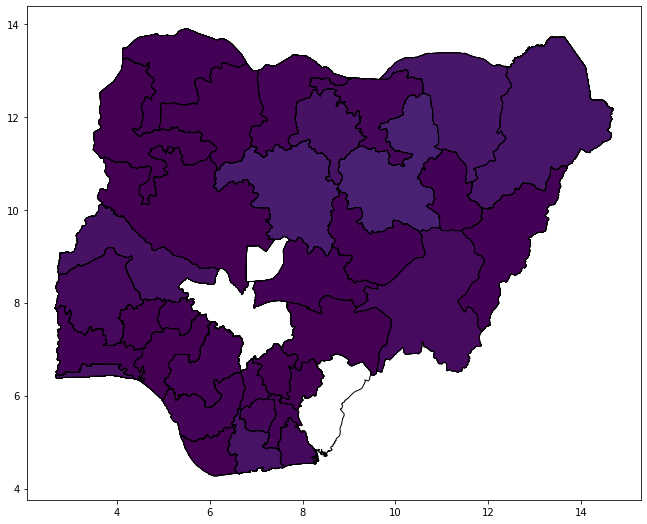

In [19]:
states_file = "docs/content/nga_admbnda_osgof_eha_itos.gdb/nga_admbnda_osgof_eha_itos.gdb/nga_admbnda_osgof_eha_itos.gdb/nga_admbnda_osgof_eha_itos.gdb/"

# geopandas included map, filtered to just Nigeria
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.crs = "EPSG:4326"
nigeria = world[(world['name'] == 'Nigeria')]
base = nigeria.plot(color='white', edgecolor='black', alpha=0, figsize=(11, 11))

layers = fiona.listlayers(states_file)
zones_gdf = gpd.read_file(states_file, layer=1)
zones_gdf = zones_gdf.merge(adm1_plot, on='admin1Pcode', how='left')
zones_gdf = zones_gdf.merge(state_cases, on='admin1Pcode', how='left')
zones_gdf['case_rate'] = zones_gdf['total_cases'] / zones_gdf['population']
zones_gdf.crs = "EPSG:4326"
zones_gdf = zones_gdf.set_index('admin1Name_en')
zones_gdf.plot(ax=base, column='total_cases', edgecolor='black')

plt.show()

## Plotting cases by State

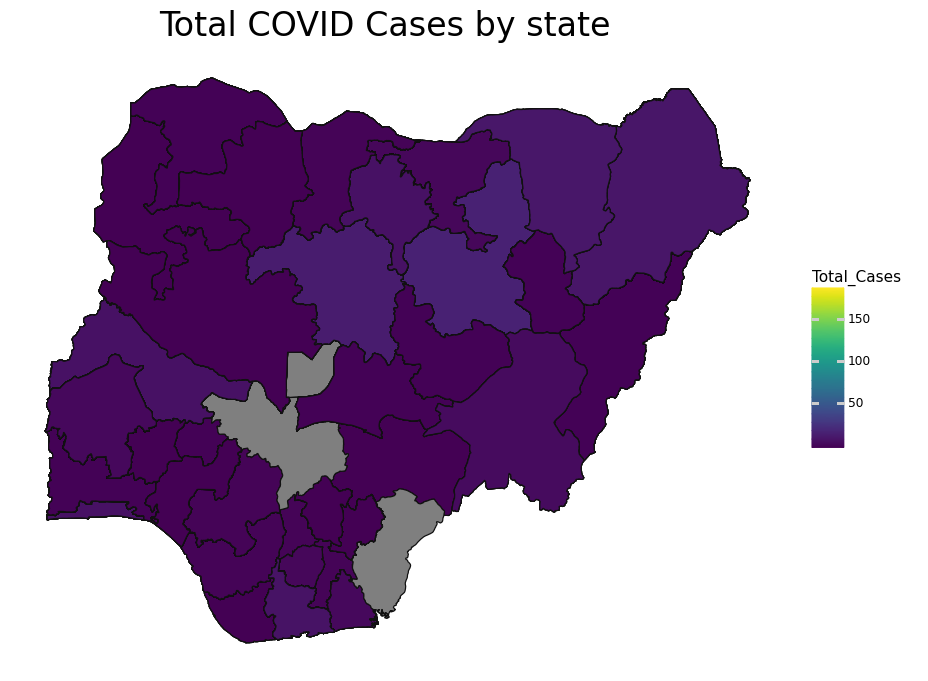

<ggplot: (131640938054)>

In [20]:
states_file = "docs/content/nga_admbnda_osgof_eha_itos.gdb/nga_admbnda_osgof_eha_itos.gdb/nga_admbnda_osgof_eha_itos.gdb/nga_admbnda_osgof_eha_itos.gdb/"

# geopandas included map, filtered to just Nigeria
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.crs = "EPSG:4326"
nigeria = world[(world['name'] == 'Nigeria')]
# base = nigeria.plot(color='white', edgecolor='black', alpha=0, figsize=(11, 11))

layers = fiona.listlayers(states_file)
zones_gdf = gpd.read_file(states_file, layer=1)
zones_gdf = zones_gdf.merge(adm1_plot, on='admin1Pcode', how='left')
zones_gdf = zones_gdf.merge(state_cases, on='admin1Pcode', how='left')
zones_gdf['case_rate'] = zones_gdf['total_cases'] / zones_gdf['population']
zones_gdf.crs = "EPSG:4326"
zones_gdf = zones_gdf.set_index('admin1Name_en')

(ggplot(zones_gdf)
 + geom_map(zones_gdf, aes(fill = 'total_cases'))
 + ggtitle('Total COVID Cases by state')
 + labs(fill = 'Total_Cases')
 + theme_minimal()
 + coord_fixed()
 + theme(axis_text = element_blank(),
         panel_grid = element_blank(),
         plot_title = element_text(size=24),
        figure_size = (10,12)))

## Animated plotnine chart

In [21]:
max(cases_df['date']) + datetime.timedelta(days=1)

Timestamp('2020-05-20 00:00:00')

In [22]:
int(str(max(cases_df['date']) - min(cases_df['date'])).split(' ', 1)[0])

82

In [23]:
state_cases

,date,total_cases,admin1Pcode
0,2020-05-01,3,NG013
1,2020-05-19,1,NG014
2,2020-04-24,75,NG025
3,2020-05-08,4,NG033
4,2020-04-18,1,NG018
...,...,...,...
564,2020-04-16,19,NG025
565,2020-05-11,1,NG029
566,2020-05-12,3,NG021
567,2020-04-10,3,NG021


In [24]:
state_cases

,date,total_cases,admin1Pcode
0,2020-05-01,3,NG013
1,2020-05-19,1,NG014
2,2020-04-24,75,NG025
3,2020-05-08,4,NG033
4,2020-04-18,1,NG018
...,...,...,...
564,2020-04-16,19,NG025
565,2020-05-11,1,NG029
566,2020-05-12,3,NG021
567,2020-04-10,3,NG021


In [30]:
states_file = "docs/content/nga_admbnda_osgof_eha_itos.gdb/nga_admbnda_osgof_eha_itos.gdb/nga_admbnda_osgof_eha_itos.gdb/nga_admbnda_osgof_eha_itos.gdb/"

# geopandas included map, filtered to just Nigeria
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.crs = "EPSG:4326"
nigeria = world[(world['name'] == 'Nigeria')]
# base = nigeria.plot(color='white', edgecolor='black', alpha=0, figsize=(11, 11))

#state_cases[state_cases['date'] <= _date]

layers = fiona.listlayers(states_file)
zones_gdf = gpd.read_file(states_file, layer=1)
zones_gdf = zones_gdf.merge(adm1_plot, on='admin1Pcode', how='left')
zones_gdf = zones_gdf.merge(state_cases, on='admin1Pcode', how='left')
zones_gdf['case_rate'] = zones_gdf['total_cases'] / zones_gdf['population']
zones_gdf.crs = "EPSG:4326"
zones_gdf = zones_gdf.set_index('admin1Name_en')

nga_anim = zones_gdf.copy()
nga_anim['date_y'] = pd.to_datetime(nga_anim['date_y'])

date_to_days = pd.DataFrame(nga_anim['date_y'] - min(cases_df['date']))
date_to_days['date_y'] = date_to_days['date_y'].astype(str)
date_to_days[['days_since_first_case', 'days_text']] = date_to_days['date_y'].str.split(' ', 1, expand=True)
nga_anim = nga_anim[date_to_days['days_since_first_case'] != 'NaT']
date_to_days = date_to_days[date_to_days['days_since_first_case'] != 'NaT']

date_to_days['days_since_first_case'] = date_to_days['days_since_first_case'].astype(int)

In [26]:
nga_anim['days_since_first_case'] = date_to_days['days_since_first_case']


nga_anim.head()

NameError: name 'date_to_days' is not defined

In [27]:
nga_anim.columns

NameError: name 'nga_anim' is not defined

In [28]:
min(pd.to_datetime(state_cases['date'])) + pd.DateOffset(1)

Timestamp('2020-02-28 00:00:00')

In [29]:
from plotnine.animation import PlotnineAnimation
from matplotlib import animation

# for animation in the notebook
from matplotlib import rc
rc('animation', html='html5')

# Parameters used to control the spiral
n = 82
kmin = 0
kmax = 82
num_frames = 164

states_file = "docs/content/nga_admbnda_osgof_eha_itos.gdb/nga_admbnda_osgof_eha_itos.gdb/nga_admbnda_osgof_eha_itos.gdb/nga_admbnda_osgof_eha_itos.gdb/"

# geopandas included map, filtered to just Nigeria
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.crs = "EPSG:4326"
nigeria = world[(world['name'] == 'Nigeria')]
# base = nigeria.plot(color='white', edgecolor='black', alpha=0, figsize=(11, 11))

def plot(k):
    # For every plot we change the theta
    state_cases['date'] = pd.to_datetime(state_cases['date'])
    
    _date = min(state_cases['date']) + pd.DateOffset(k.round(decimals=0))
    
    states = state_cases[state_cases['date'] <= pd.to_datetime(_date)]
    
    states_sum = (
    tp.from_pandas(states)
    .summarize(total_cases = tp.sum(col('total_cases')),
               by='admin1Pcode')
        )
    
    states_sum = states_sum.to_pandas()
    
    layers = fiona.listlayers(states_file)
    zones_gdf = gpd.read_file(states_file, layer=1)
    zones_gdf = zones_gdf.merge(adm1_plot, on='admin1Pcode', how='left')
    zones_gdf = zones_gdf.merge(states_sum, on='admin1Pcode', how='left')
    zones_gdf['case_rate'] = zones_gdf['total_cases'] / zones_gdf['population']
    zones_gdf.crs = "EPSG:4326"
    zones_gdf = zones_gdf.set_index('admin1Name_en')

    nga_anim = zones_gdf.copy()
#     nga_anim['date_y'] = pd.to_datetime(nga_anim['date_y'])

#     date_to_days = pd.DataFrame(nga_anim['date_y'] - min(cases_df['date']))
#     date_to_days['date_y'] = date_to_days['date_y'].astype(str)
#     date_to_days[['days_since_first_case', 'days_text']] = date_to_days['date_y'].str.split(' ', 1, expand=True)
#     nga_anim = nga_anim[date_to_days['days_since_first_case'] != 'NaT']
#     date_to_days = date_to_days[date_to_days['days_since_first_case'] != 'NaT']

#     date_to_days['days_since_first_case'] = date_to_days['days_since_first_case'].astype(int)
    
#     nga_anim['days_since_first_case'] = date_to_days['days_since_first_case']

#     #df = nga_anim[nga_anim['days_since_first_case'] <= _date]
#     nga_anim['alpha'] = 100 - (k - nga_anim['days_since_first_case'])
    
#     # group and summarise with tp
#     df = (
#     tp.from_pandas(df)
#     .summarize(total_cases = tp.sum(col('total_cases')),
#                population = tp.sum(col('population')),
#                case_rate = col('total_cases') / col('population'),
#               by = ['admin1Pcode', 'admin1RefName', 'admin1AltName1_en',
#        'admin1AltName2_en', 'admin0Name_en', 'admin0Pcode', 'date_x',
#        'validOn', 'validTo', 'Shape_Length', 'Shape_Area', 'geometry'])
# #     )
    
#     df = anim_df.to_pandas()

    p = (ggplot(nga_anim)
 + geom_map(nga_anim, aes(fill = 'total_cases'))
 + ggtitle('Total COVID Cases by state')
 + scale_fill_continuous(limits=(0, 500))
 + labs(fill = 'Total_Cases')
 + theme_minimal()
 + coord_fixed()
 + theme(axis_text = element_blank(),
         panel_grid = element_blank(),
         plot_title = element_text(size=24),
        figure_size = (10,12)))
    
    return p

# It is better to use a generator instead of a list
plots = (plot(k) for k in np.linspace(kmin, kmax, num_frames))
ani = PlotnineAnimation(plots, interval=100, repeat_delay=500)
# ani.save('animation.gif')
#ani

writergif = animation.PillowWriter(fps=30)
ani.save('animation.gif',writer=writergif)

## Attempt to make a slider to control dates

In [165]:
import datetime as dt
import panel as pn

pn.extension()

In [167]:
date_range_slider = pn.widgets.DateRangeSlider(
    name='Date Range Slider',
    start=dt.datetime(2020, 4, 1), end=dt.datetime(2020, 5, 1),
    value=(dt.datetime(2020, 4, 1), dt.datetime(2020, 4, 1)),
)

date_range_slider

DateRangeSlider(end=datetime.datetime(2020, ..., name='Date Range Slider', start=datetime.datetime(2020, ..., value=(datetime.datetime(2020, ..., value_end=datetime.datetime(2020, ..., value_start=datetime.datetime(2020, ...)

NameError: name 'amp_slider' is not defined

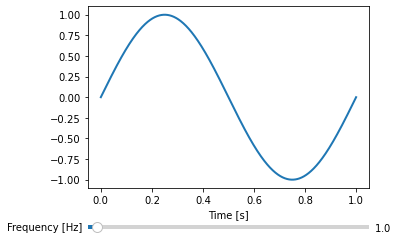

In [171]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


# The parametrized function to be plotted
def f(t, amplitude, frequency):
    return amplitude * np.sin(2 * np.pi * frequency * t)

t = np.linspace(0, 1, 1000)

# Define initial parameters
init_amplitude = 1
init_frequency = 1

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line, = plt.plot(t, f(t, init_amplitude, init_frequency), lw=2)
ax.set_xlabel('Time [s]')

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = plt.axes([0.25, 0.1, 0.65, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='Frequency [Hz]',
    valmin=0.1,
    valmax=30,
    valinit=init_frequency,
)


# The function to be called anytime a slider's value changes
def update(val):
    line.set_ydata(f(t, amp_slider.val, freq_slider.val))
    fig.canvas.draw_idle()


# register the update function with each slider
freq_slider.on_changed(update)
amp_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    freq_slider.reset()
    amp_slider.reset()
button.on_clicked(reset)

plt.show()

In [174]:
import plotly.graph_objects as go
import numpy as np

# Create figure
fig = go.Figure()

# Add traces, one for each slider step
for step in np.arange(0, 5, 0.1):
    fig.add_trace(
        go.Scatter(
            visible=False,
            line=dict(color="#00CED1", width=6),
            name="𝜈 = " + str(step),
            x=np.arange(0, 10, 0.01),
            y=np.sin(step * np.arange(0, 10, 0.01))))

# Make 10th trace visible
fig.data[10].visible = True

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to step: " + str(i)}],  # layout attribute
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Frequency: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

fig.show()

ModuleNotFoundError: No module named 'plotly'